In [5]:
import tensorflow as tf
import cv2
import random
import numpy as np
import tensorflow_triplet_loss.model.triplet_loss as triplet_loss
from functools import wraps
import time
from tqdm import tqdm
from einops import rearrange, reduce, repeat
import tensorflow_addons as tfa
import os

In [2]:
mode = 'gaitset'
date = '2022_11_3_14_40'
gaitset = tf.keras.models.load_model(f'E:/ITRI_SSTC/S100/College-level_Applied_Research/gait_log/{mode}/{date}/gaitset/trained_ckpt')

In [6]:
def readTFRECORD(tfrecord_file_path):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    data_set = tf.data.TFRecordDataset(tfrecord_file_path)
    data_set = data_set.map(parse, num_parallel_calls=AUTOTUNE)

    data_set = data_set.shuffle(
        1000, reshuffle_each_iteration=True)
    data_batch = data_set.batch(8, drop_remainder=True)
    data_batch = data_batch.prefetch(buffer_size=AUTOTUNE)
    return data_batch

def parse(example_proto):

        features = tf.io.parse_single_example(
            example_proto,
            features={
                'imgs': tf.io.FixedLenFeature([], tf.string),
                'subject': tf.io.FixedLenFeature([], tf.string)
            }
            
        )
        imgs = features['imgs']
    
        subject = features['subject']
    
        imgs = tf.io.decode_raw(imgs, np.float32)
        subject = tf.io.decode_raw(subject, np.float32)
        
    
        
        imgs = tf.reshape(imgs, (4, 16, 64, 64, 1))

        subject = tf.reshape(subject, (4,))
        
        
        

        return [imgs, subject]

In [7]:
vali_data_batch = readTFRECORD(r'E:\ITRI_SSTC\S100\gait\tf_record\gaitset_train_64x64_16k_4p.tfrecords')

In [8]:
prob = []
gallery = []

prob_label_clt = []
gallery_label_clt = []
for step, batch in enumerate(tqdm(vali_data_batch)):
    validate_imgs, validate_subjects = batch

    prob_imgs = validate_imgs[:, 0:2, :, :, :, :]
    gallery_imgs = validate_imgs[:, 2:, :, :, :, :]

    # validate_imgs = rearrange(validate_imgs, 'b p s h w c -> (b p) s h w c')

    prob_imgs = rearrange(prob_imgs, 'b p s h w c -> (b p) s h w c')
    gallery_imgs = rearrange(gallery_imgs, 'b p s h w c -> (b p) s h w c')

    prob_feature= gaitset(prob_imgs)
    gallery_feature= gaitset(gallery_imgs)


    prob_feature = rearrange(prob_feature, 'b h c -> b (h c)')
    gallery_feature = rearrange(gallery_feature, 'b h c -> b (h c)')


    prob.append(prob_feature)
    gallery.append(gallery_feature)

    prob_label = validate_subjects[:, 0:2]
    gallery_label = validate_subjects[:, 2:]

    prob_label = rearrange(prob_label, 'b p -> (b p)')
    gallery_label = rearrange(gallery_label, 'b p -> (b p)')

    prob_label_clt.append(prob_label)
    gallery_label_clt.append(gallery_label)


prob = np.concatenate( prob, axis=0 )
gallery = np.concatenate( gallery, axis=0 )

prob_label_clt = np.concatenate( prob_label_clt, axis=0 )
gallery_label_clt = np.concatenate( gallery_label_clt, axis=0 )

# RANK1
cos_correct_cnt = 0
mse_correct_cnt = 0

cosine = tf.keras.losses.CosineSimilarity(axis=1,
            reduction=tf.keras.losses.Reduction.NONE)
mse = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.NONE)

for i, p in enumerate(tqdm(prob)):
    p = np.tile(p, prob.shape[0]).reshape(prob.shape[0], -1)

    #cosine
    cosine_loss = cosine(gallery, p).numpy()
    cosine_loss_predict_label = gallery_label_clt[np.argmin(cosine_loss)]

    #Ecludiense
    mse_loss = mse(gallery, p).numpy()
    mse_predict_label = gallery_label_clt[np.argmin(mse_loss)]

    if cosine_loss_predict_label == prob_label_clt[i]:
        cos_correct_cnt+=1
    if mse_predict_label == prob_label_clt[i]:
        mse_correct_cnt+=1

print(f'Rank1: \n \
cos:{(cos_correct_cnt / prob.shape[0]) * 100}%, mse: {(mse_correct_cnt / prob.shape[0]) * 100}%')

641it [00:41, 15.28it/s]
100%|████████████████████████████████████████████████████████████| 10256/10256 [1:10:47<00:00,  2.41it/s]

Rank1: 
 cos:91.17589703588143%, mse: 91.23439937597504%


# Test from folder

In [39]:
import itertools
import random
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from einops import rearrange, reduce, repeat

In [18]:
def file_exist(path):
    file = pathlib.Path(path)
    return file.exists()

class OU_MVLP_person():
    def __init__(self, sequence: str, subject: str, img_per_person:int):
        '''  
        keywargs:
            sequence: '00' or '01',
            subject: a string. ID of a person.
            k: a int. Number of images should read for a single person.
        '''
        
        self.subject = str(subject).zfill(5)
        self.sequence = sequence
        self.img_per_person = img_per_person
        self.possible_angles = [i for i in range(0, 91, 15)] + [i for i in range(180, 271, 15)]
        
      
        
        self.None_Exist = False
        self.img_list = []

        
    def load_gait_image(self, path):
        
        for k in range(self.img_per_person):
            while True:
                angle = random.sample(self.possible_angles, 1)[0]
                full_path = f'{path}/Silhouette_{str(angle).zfill(3)}-{self.sequence}/{self.subject}'
                if file_exist(full_path):
                    total_img_filenames = os.listdir(full_path)
                    img_filename = random.sample(total_img_filenames, 1)[0]

                    img = cv2.imread(f'{full_path}/{img_filename}', 0)
                    img = img.reshape((64, 64, 1))
                    self.img_list.append(img)
                    break

In [13]:
path = 'E:/ITRI_SSTC/S100/gait/OUMVLP_process'
sequence = '00'
total_subject = [i for i in range(10307)]

for subject in range(10307):
    exist = 0
    for angle in [i for i in range(0, 91, 15)] + [i for i in range(180, 271, 15)]:
        if os.path.isdir(f'{path}/Silhouette_{str(angle).zfill(3)}-{sequence}/{str(subject).zfill(5)}'):
            exist +=1
    if exist < 5:
        print(subject)
        total_subject.remove(subject)

0
385
798
965
1149
2193
2485
2893
3508
3585
3744
4334
4485
4544
4572
4575
4601
4634
4640
4643
4660
4663
5397
5915
6005
6086
7053
7205
7295
7449
7462
7515
8271
9043
9209
9318
9786
10023
10027
10033
10280
10283


In [14]:
random.shuffle(total_subject)
train_subject = total_subject[:5132]
test_object = total_subject[5132:]

In [26]:
def load_data(data_path, phase, k, p):

    # '00' for training and '01' for testing
    if phase == 'Train':
        sequence = '00'
    elif phase == 'Test':
        sequence = '01'
    else:
        print('Wrong phase input.')
        print('Option: "Train" or "Test"')
        return
        
    # angle = [0, 15, 30, ..., 270]
    angles = [i for i in range(0, 91, 15)] + [i for i in range(180, 271, 15)]
    # 10307 subjects
    subject_nums = 10307
    path = data_path
    shape = 10
    gait_silh = np.zeros((shape, p, k, 64, 64, 1))
    label = np.zeros((shape, p))
    cnt = 0
    for i, sub in enumerate(test_object[:10]):
        person_list = []
        subject_list = []
#             None_exist_list = []

        while True:
            person = OU_MVLP_person(sequence = sequence, subject = sub, img_per_person = k)
            person.load_gait_image(path)
            person_list.append(person.img_list)
            subject_list.append(np.float32(person.subject))
#                 None_exist_list.append(person.None_Exist)
            
            if len(person_list) >= p:
                break
 
        imgs = np.array(person_list)
        gait_silh[i] = imgs
        subject = np.array(subject_list)
        label[i] = subject
    return gait_silh, label

In [28]:
gait_silh, label = load_data(r'E:\ITRI_SSTC\S100\gait\OUMVLP_process', 'Train', k=16, p=4)

In [30]:
gait_silh.shape

(10, 4, 16, 64, 64, 1)

# Draw

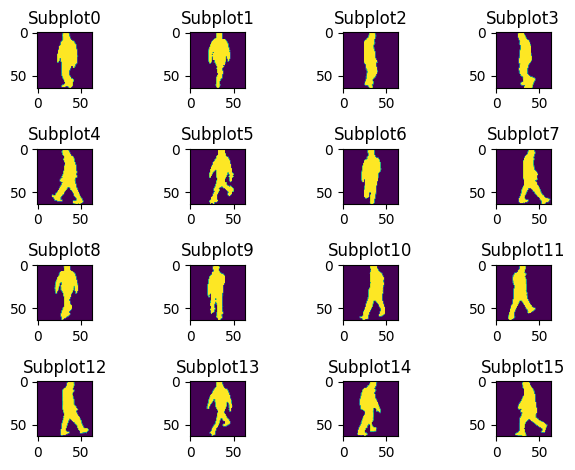

In [37]:
import numpy as np
import matplotlib.pyplot as plt

width=5
height=5
rows = 4
cols = 4
axes=[]
fig=plt.figure()

ppl = 5

for i in range(16):
    b = gait_silh[ppl][0][i].astype('uint8')
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("Subplot"+str(i))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()    
plt.show()

In [45]:
label.shape

(10, 4)

In [44]:
gait_silh.shape

(10, 4, 16, 64, 64, 1)

In [47]:
gait_silh_reshape = rearrange(gait_silh, 'b p k h w c -> (b p) k h w c')
label_reshape = rearrange(label, 'b p -> (b p)')

In [56]:
gait_embedding = gaitset(gait_silh_reshape)

In [60]:
gait_embedding = rearrange(gait_embedding, 'b h c -> b (h c)')

In [68]:
for i, feature in enumerate(gait_embedding):
    print(f'Featur {i}: ', np.sum((gait_embedding[31] - feature) **2) ** 0.5)

Featur 0:  11911.572860038257
Featur 1:  12872.97199561935
Featur 2:  11114.36907790991
Featur 3:  13161.111199287088
Featur 4:  13555.400399840648
Featur 5:  13137.948698331867
Featur 6:  13022.095069534702
Featur 7:  13678.326213393217
Featur 8:  16611.16636482821
Featur 9:  16289.684588720556
Featur 10:  15348.05160272795
Featur 11:  14147.983036461417
Featur 12:  11690.083318779212
Featur 13:  12659.089382732078
Featur 14:  12693.418767219491
Featur 15:  12727.106191118231
Featur 16:  12547.924768661947
Featur 17:  12156.974623647118
Featur 18:  13649.249649706024
Featur 19:  12133.002925904206
Featur 20:  21133.67284690477
Featur 21:  20216.7423686409
Featur 22:  21641.799555489833
Featur 23:  20667.0644262798
Featur 24:  19984.331462423255
Featur 25:  20869.134337580945
Featur 26:  21340.573937923975
Featur 27:  20764.54670827177
Featur 28:  5486.7895895505235
Featur 29:  4199.76285044763
Featur 30:  5607.366940017391
Featur 31:  0.0
Featur 32:  14490.877682183367
Featur 33:  146